In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import NearestNeighbors

# Homework reflection 1

1. In Coding Quiz 1, you are asked to find the distance of the farthest match in a set.  Is this farthest match distance too far to be a meaningful match?  How can you decide this?

A farthest match distance of 0.21 may or may not be meaningful depending on the scale of Z. If Z values range narrowly (e.g., 0-0.3), 0.21 indicates a weak match. it is negligible if they span several units. To determine if they are too far, we can compare this value to the overall distance distribution - if it’s near the high end, the match is poor. Plotting distances or checking percentile ranks can clarify this further. A match is meaningful if removing distant pairs doesn’t change downstream results, or else the distance is too large to trust.

A farthest match distance of 0.21 is acceptable, it’s not too large to invalidate the match. The resulting effect size (0.54) is close to what;s expected from proper pairing, meaning that the matches still capture comparable Z values between x=0 and x=1 groups.

2. In Coding Quiz 1, there are two approaches to matching: 
(A) Picking the best match X = 0 corresponding to each X = 1 using Z values.
(B) Using radius_neighbors to pick all matches X = 0 within a distance of 0.2 of each X = 1.

Invent your own type of matching similar to 1 and 2 (or look one up on the internet), which has a different way to pick the matches in X = 0.  Clearly explain the approach you invented or found.

Locality Sensitive Hashing:
https://www.pinecone.io/learn/series/faiss/locality-sensitive-hashing/
https://en.wikipedia.org/wiki/Locality-sensitive_hashing

Locality Sensitive Hashing (LSH) is a method I found online for matching that uses hash functions that preserve similarity so that points close in Z-space are grouped into the same “bucket.” For each x=1, we'd only need to search within its bucket (or nearby ones) to find matching X = 0 values. This skips full pairwise comparisons and scales well for high-dimensional data, making it an efficient matching algorithm.

Once candidates are retrieved from these buckets, we can then rank them by the exact distance and either choose the closest match or average over all within a small threshold. This method givves a good balance of accuracy and efficiency, giving results close to NearestNeighbors but much faster on large datasets.


# Homework reflection 2

1. Invent an example situation that would use fixed effects.

Let's say we want to study the impact of a new electronic lab notebook (ELN) on data-entry speed across multiple labs over several months. Each lab has time-invariant quirks like staffing norms, bench layout, legacy SOPs, etc. that affect their baseline speed but don’t change quickly. If we use a fixed-effect model Yit​ = αi ​+ βELNit​ + εit where 
i indexes labs and t is time. αi absorbs each lab’s unobserved, constant factors, so β isolates how adopting the ELN changes speed within a lab over time. (optionally we can add time fixed effects to soak up month-wide shocks.)

This matches the coding quiz setup: one common slope β for all groups, plus group fixed effects. Interpretation: β is a within-lab contrast (post vs. pre ELN) net of each lab’s baseline level, avoiding bias from cross-lab differences.

2. Write a Python program that performs a bootstrap simulation to find the variance in the mean of the Pareto distribution when different samples are taken.  Explain what you had to do for this.  As you make the full sample size bigger (for the same distribution), what happens to the variance of the mean of the samples?  Does it stay about the same, get smaller, or get bigger?


In [2]:
def bootstrap_mean_variance_pareto(alpha=3.0, xm=1.0, n=200, B=5000, seed=0):
    rng = np.random.default_rng(seed)
    means = []
    for _ in range(B):
        # Pareto with scale xm and shape alpha (NumPy’s pareto returns samples of xm*(1+X))
        x = xm * (1 + rng.pareto(alpha, size=n))
        means.append(np.mean(x))
    return np.var(means, ddof=1)

if __name__ == "__main__":
    for n in [50, 100, 200, 500, 1000]:
        v = bootstrap_mean_variance_pareto(alpha=3.0, xm=1.0, n=n, B=5000, seed=42)
        print(f"n={n:4d}  Var(bootstrap mean)≈ {v:.6f}")


n=  50  Var(bootstrap mean)≈ 0.014589
n= 100  Var(bootstrap mean)≈ 0.006883
n= 200  Var(bootstrap mean)≈ 0.003673
n= 500  Var(bootstrap mean)≈ 0.001484
n=1000  Var(bootstrap mean)≈ 0.000720


I picked a shape "alpha" and scale "xm" for a pareto distribuiton, I chose a sample size "n", and a large number of bootstrap draws B (5000 here). For each bootstrap draw, we sample n values with replacement from the pareto, compute the sample mean, and store it. After B draws, we compute the variance across those B means and return it from the function. Then we repeat the whole procedure for bigger n (here: 50, 100, 200, 500, 1000) to see how the variance of the mean changes - using a fixed random seed for reproducibility. Siince numpy's pareto returns values for a distribution supported on zero to infinity, I transformed it with xm * (1 + pareto) to get the standard pareto with the xm.

As n grows, if alpha is greater than 2, the variance of the sample mean gets smaller roughly like one over n. So doubling n cuts that variance about in half, and the standard error shrink - in this case, from 0.014 (n=50) to 0.000720 (n=1000). If alpha is <=2, the population variance is infinite - then the bootstrap variance may not settle down with larger n. Effectively, the variance gets smaller as n becomes bigger.

# Homework reflection 3

1. In the event study in Coding Quiz 3, how would we go about testing for a change in the second derivative as well?

To test for a change in the second derivative, we can fit a piecewise quadratic model. Frist, we set the event time as t0=50 (since the event is at t=50 in the quiz) and create tc = t - 50 so the event is at tc=0. Then make an indicator variable called post that is 1 for times at or after the event (t >= 50) and 0 before the event (t<50). We can then regress y on:
 - 1 (intercept)
 - post (possible jump at the event)
 - tc (slope)
 - post * tc (change in slope after the event)
 - tc^2 (curvature)
 - post * tc^2 (extra curvature after the event) 

The key test is whether the coefficient on post * tc^2 is different from zero; if it is, the second derivative changes after the event. Centering time this way makes the intercept and slope refer to the moment of the event and helps avoid multicollinearity between tc and tc^2. Because it’s a time series, we can use robust or Newey–west standard errors and perform sanity checks by repeating the test in a narrower window like 40–60 to see if the result is stable.

2. Create your own scenario that illustrates differences-in-differences. Describe the story behind the data and show whether there is a nonzero treatment effect.

Briefly, DiD compares changes over time in a treated group to changes over time in a comparable control group. If the groups would have followed parallel trends absent the intervention, the difference of their before–after differences identifies the treatment effect.

Scenario and result: if a hospital system rolls out a new sepsis alert in Hospital T in July; Hospital C does not adopt it that year. The outcome is sepsis mortality per 1,000 admissions. Pre-period (Jan–Jun): T = 12.0, C = 11.5. Post-period (Jul–Dec): T = 9.0, C = 11.0. Changes: T drops 3.0, C drops 0.5 (seasonal improvement). 

The DiD estimate is (9.0−12.0) − (11.0−11.5) = −3.0 − (−0.5) = −2.5, indicating a 2.5 per 1,000 reduction that can be attributed to the alert. If we implement this via a regression with an intercept, a post indicator, a treated indicator, and their interaction; the interaction coefficient is the DiD effect. Interpreting whether or not this is causal depends on plausibly parallel pre-trends and no concurrent changes differentially affecting Hospital T during the period.


# Homework reflection 4

1. The Coding Quiz gives two options for instrumental variables.  For the second item (dividing the range of W into multiple ranges), explain how you did it, show your code, and discuss any issues you encountered.


In [3]:
# load data
df = pd.read_csv("/Users/amit/Desktop/Current Classes/Y2S1 Experimental Design and Causality/DX702-mod-6/homework_4.1.csv")

def wald_global(d):
    m = d.groupby("Z")[["Y","X"]].mean()
    dy = m.loc[1,"Y"] - m.loc[0,"Y"]
    dx = m.loc[1,"X"] - m.loc[0,"X"]
    return dy/dx, dy, dx

def wald_binned(d, nbins=10, min_per_cell=5, weak_tol=1e-6, weighted=True):
    d = d.copy()
    d["W_bin"] = pd.qcut(d["W"], q=nbins, duplicates="drop")
    g = d.groupby(["W_bin","Z"]).agg(Y=("Y","mean"), X=("X","mean"), n=("Y","size"))
    have = g.reset_index().pivot(index="W_bin", columns="Z", values="n").dropna()
    ok = have[(have[0] >= min_per_cell) & (have[1] >= min_per_cell)].index
    rows = []
    for b in ok:
        y1,y0 = g.loc[(b,1),"Y"], g.loc[(b,0),"Y"]
        x1,x0 = g.loc[(b,1),"X"], g.loc[(b,0),"X"]
        dy, dx = (y1-y0), (x1-x0)
        if abs(dx) <= weak_tol:  # avoid ~zero first stage
            continue
        rows.append({"bin":str(b), "theta":dy/dx, "dx":dx, "dy":dy, "n":g.loc[(b,1),"n"]+g.loc[(b,0),"n"]})
    out = pd.DataFrame(rows)
    if out.empty: return np.nan, out
    w = out["n"] if weighted else None
    return np.average(out["theta"], weights=w), out.sort_values("bin")

tg, dYg, dXg = wald_global(df)
tb_w, detail_w = wald_binned(df, nbins=10, min_per_cell=5, weak_tol=1e-6, weighted=True)
tb_u, detail_u = wald_binned(df, nbins=10, min_per_cell=5, weak_tol=1e-6, weighted=False)

print("Global Wald θ =", round(tg,4), "| ΔY =", round(dYg,4), "| ΔX =", round(dXg,4))
print("Binned Wald (weighted) θ =", round(tb_w,4))
print("Binned Wald (unweighted) θ =", round(tb_u,4))

Global Wald θ = 1.5619 | ΔY = 1.5908 | ΔX = 1.0186
Binned Wald (weighted) θ = 1.5089
Binned Wald (unweighted) θ = 1.5089


/var/folders/pl/w8_gtks92n9flgwzrb6qkssr0000gn/T/ipykernel_56845/1697388071.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = d.groupby(["W_bin","Z"]).agg(Y=("Y","mean"), X=("X","mean"), n=("Y","size"))
/var/folders/pl/w8_gtks92n9flgwzrb6qkssr0000gn/T/ipykernel_56845/1697388071.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  g = d.groupby(["W_bin","Z"]).agg(Y=("Y","mean"), X=("X","mean"), n=("Y","size"))


I split W into quantile buckets, and then compared the average Y between Z=1 and Z=0, and did the same for X. The ratio change in Y over change in X in that bucket is the local effect. I then averaged thse effects across buckets (with and without weighting), which lines up with the divide-W-into-ranges. I then computed local Wald using the fucntion "wald_global", and then average instruction.

If the change in X in a bin is near zero, the denominator is near zero and the ratio is unreliably high, so I drop those bins using a small threshold. I also require each bin to include both Z=0 and Z=1 with a minimum number of observations before using it. On the HW CSV 4.1, the global Wald is 1.5619 from applying these rules, and the binned Wald is 1.5089. Both weighted and unweighted versions are the same.

2. Plot the college outcome (Y) vs. the test score (X) in a small range of test scores around 80. On the plot, compare it with the Y probability predicted by logistic regression. The ground truth Y value is 0 or 1; don't just plot 0 or 1 - that will make it unreadable.  Find some way to make it look better than that.

/var/folders/pl/w8_gtks92n9flgwzrb6qkssr0000gn/T/ipykernel_56845/2058188876.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = win.groupby("bin").agg(


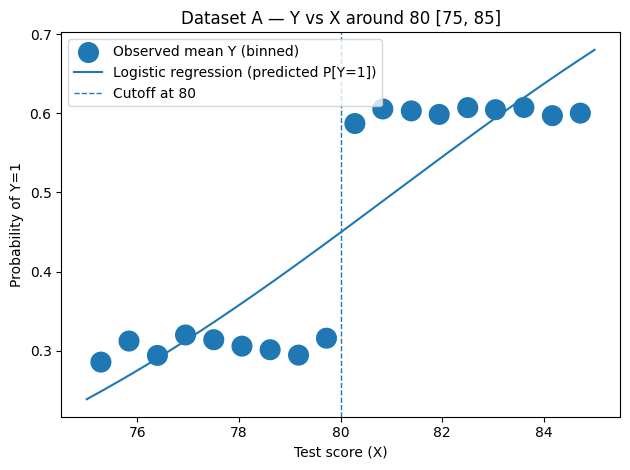

/var/folders/pl/w8_gtks92n9flgwzrb6qkssr0000gn/T/ipykernel_56845/2058188876.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  means = win.groupby("bin").agg(


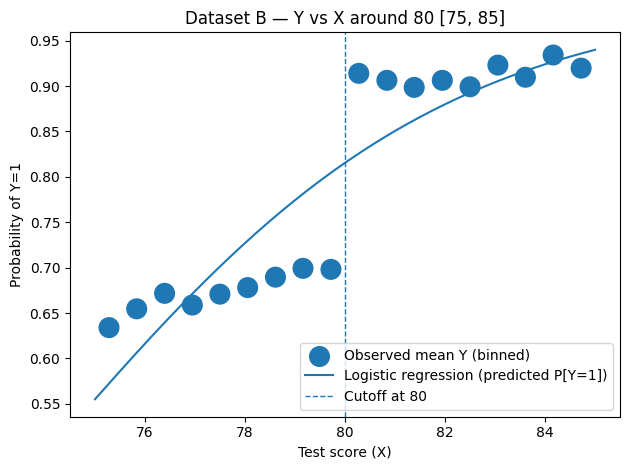

In [ ]:
def plot_window_logit(csv_path, title, x_col="X", y_col="Y", center=80, halfwidth=5, nbins=20):
    df = pd.read_csv(csv_path)
    #  small window around 80 (75 - 85)
    lo, hi = center - halfwidth, center + halfwidth
    win = df[(df[x_col] >= lo) & (df[x_col] <= hi)].copy()
    win = win.dropna(subset=[x_col, y_col])
    
    # logistic regrssion on the window
    X = win[[x_col]].values
    y = win[y_col].values.astype(int)
    model = LogisticRegression(solver="lbfgs")
    model.fit(X, y)
    
    # predicted probabilities on a grid
    grid = np.linspace(lo, hi, 200).reshape(-1, 1)
    p_hat = model.predict_proba(grid)[:, 1]
    
    # bin data to make observed 0/1 more readable
    bins = np.linspace(lo, hi, nbins+1)
    win["bin"] = pd.cut(win[x_col], bins=bins, include_lowest=True)
    means = win.groupby("bin").agg(
        x_mid=(x_col, "mean"),
        y_rate=(y_col, "mean"),
        n=(y_col, "size")
    ).dropna()
    
    # plot
    plt.figure()
    # binned mean outcome
    plt.scatter(means["x_mid"], means["y_rate"], s=np.clip(means["n"]*2, 10, 200), label="Observed mean Y (binned)")
    # logistic regression curve
    plt.plot(grid.ravel(), p_hat, label="Logistic regression (predicted P[Y=1])")

    # make it purdy
    plt.axvline(center, linestyle="--", linewidth=1, label="Cutoff at 80")
    plt.title(f"{title} — Y vs X around 80 [{lo}, {hi}]")
    plt.xlabel("Test score (X)")
    plt.ylabel("Probability of Y=1")
    plt.legend()
    plt.tight_layout()
    plt.show()

# plot for each dataset
plot_window_logit("/Users/amit/Desktop/Current Classes/Y2S1 Experimental Design and Causality/DX702-mod-6/homework_4.2.a.csv", "Dataset A", halfwidth=5, nbins=18)
plot_window_logit("/Users/amit/Desktop/Current Classes/Y2S1 Experimental Design and Causality/DX702-mod-6/homework_4.2.b.csv", "Dataset B", halfwidth=5, nbins=18)


Hi Matt!